In [29]:
import cv2 as cv
import numpy as np
import base64
import os
from PIL import Image

class OPENCV:
    def __init__(self):
        self.face_cascade = cv.CascadeClassifier('cascade/face_detect.xml')
        self.eye_cascade = cv.CascadeClassifier('cascade/eye_detect.xml')
        self.recognition = cv.face.LBPHFaceRecognizer_create()
        self.path_dataset = 'dataset/'
        self.path_latih = 'training/latih.yml'
        self.path_sampleimg = 'sampleimg/'
    def set_path(self):
        if not os.path.exists(self.path_dataset):
            os.mkdir(self.path_dataset)
        if not os.path.exists(self.path_latih):
            os.mkdir(self.path_latih)
        if not os.path.exists(self.path_sampleimg):
            os.mkdir(self.path_sampleimg)
    def set_path_sampleimg_user(self, name):
        self.set_path()
        if not os.path.exists(self.path_sampleimg):
            os.mkdir(self.path_sampleimg)
        if not os.path.exists(self.path_sampleimg+name):
            os.mkdir(self.path_sampleimg+name)
    def add_sampleimg(self, user ,foto):
        try:
            self.set_path_sampleimg_user(user.username)
            jumlah = len(os.listdir(self.path_sampleimg+user.username)) + 1
            image = foto.split(',')[1]
            image_bin = image.encode('utf-8')
            image_np = np.frombuffer(base64.b64decode(image_bin), dtype=np.uint8)
            img = cv.imdecode(image_np, cv.IMREAD_COLOR)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            wajah = self.face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
            counter = 0
            for (x, y, w, h) in wajah:
                if counter == 0:
                    counter += 1
                mata = self.eye_cascade.detectMultiScale(gray[y:y+h, x:x+w], scaleFactor=1.3, minNeighbors=5)
                for (x2, y2, w2, h2) in mata:
                    if counter == 2:
                        if jumlah <= 10:
                            fnama = f"{self.path_sampleimg}{user.username}/{user.username}.{user.id}.{jumlah}.jpg"
                            cv.imwrite(fnama, img)
                    counter += 1
            print(f"[INFO] > Menyimpan {fnama}")
        except:
            print("[INFO] > Gagal Menyimpan")
    def update_dataset(self, user):
        path = self.path_sampleimg+user.username
        daftar_sampleimg = os.listdir(path)
        # jumlah = 0
        if len(daftar_sampleimg) > 0:
            for isi in daftar_sampleimg:
                counter = 0
                img = cv.imread(f'{path}/{isi}')
                gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                wajah = self.face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
                for (x, y, w, h) in wajah:
                    if counter == 0:
                        counter += 1
                    mata = self.eye_cascade.detectMultiScale(gray[y:y+h, x:x+w], scaleFactor=1.3, minNeighbors=5)
                    for (x2, y2, w2, h2) in mata:
                        if counter > 0:
                            counter += 1
                        if counter == 2:
                            # jumlah += 1
                            cv.imwrite(f'{self.path_dataset}{isi}', gray[y:y+h, x:x+w])
                # counter = 0
        self.latih_dataset()
    def latih_dataset(self):
        print('[INFO]: Start training mohon tunggu')
        list_image = os.listdir(self.path_dataset)
        sample_wajah = []
        ids = []
        for isi in list_image:
            PILimage = Image.open(self.path_dataset+isi).convert('L')
            img_numpy = np.array(PILimage, 'uint8')
            id = int(os.path.split(isi)[-1].split(".")[1])
            sample_wajah.append(img_numpy)
            ids.append(id)

        self.recognition.train(sample_wajah, np.array(ids))
        self.recognition.write(self.path_latih)
        print('[INFO]: Latih dataset selesai..')
    def deteksi_wajah(self, path_image):
        self.recognition.read(self.path_latih)
        # dummy data
        id = 0
        names = ['None', 'Uki'] # ganti dengan yang ada pada database
        prediksi = 100
        img = cv.imread(path_image)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        wajah = self.face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        for (x, y, w, h) in wajah:
            id, prediksi = self.recognition.predict(gray[y:y+h, x:x+w])
            id = names[id]
            prediksi = (100 - round(prediksi))
        return [id, prediksi]
    def seleksi_sampleimg(self, user):
        sampleimg_user_path = self.path_sampleimg+user.username
        list_sampleimg_user = os.listdir(sampleimg_user_path)
        hasil = {}
        hstatc = []
        for isi in list_sampleimg_user:
            dapat = self.deteksi_wajah(sampleimg_user_path + '/' + isi)
            hstatc.append([dapat[0], dapat[1], sampleimg_user_path + isi])
        
        hasil[user.username] = hstatc
        return hasil
    def jumlah_sampleimg_user(self,user):
        return len(os.listdir((self.path_sampleimg+user.username)))

In [4]:
class User:
    username = 'Uki'
    id = 1

In [30]:
opencv = OPENCV()

In [17]:
opencv.update_dataset(User)

[INFO]: Start training mohon tunggu
[INFO]: Latih dataset selesai..


In [28]:
hasil = opencv.seleksi_sampleimg(User)
for isi in hasil.keys():
    for data in hasil[isi]:
        print(data)

['Uki', 85, 'sampleimg/UkiUki.1.9.jpg']
['Uki', 85, 'sampleimg/UkiUki.1.6.jpg']
['Uki', 85, 'sampleimg/UkiUki.1.5.jpg']
['Uki', 89, 'sampleimg/UkiUki.1.3.jpg']
['Uki', 85, 'sampleimg/UkiUki.1.8.jpg']
['Uki', 85, 'sampleimg/UkiUki.1.2.jpg']
['Uki', 86, 'sampleimg/UkiUki.1.4.jpg']
['Uki', 84, 'sampleimg/UkiUki.1.1.jpg']
['Uki', 88, 'sampleimg/UkiUki.1.7.jpg']
['Uki', 84, 'sampleimg/UkiUki.1.10.jpg']


In [32]:
print(opencv.jumlah_sampleimg_user(User))

10


In [6]:
print(User.id)

1


In [ ]:
import cv2 as cv
import numpy as np
import base64
import os
from PIL import Image

class OPENCV:
    def __init__(self):
        self.face_cascade = cv.CascadeClassifier('cascade/face_detect.xml')
        self.eye_cascade = cv.CascadeClassifier('cascade/eye_detect.xml')
        self.recognition = cv.face.LBPHFaceRecognizer_create()
        self.path_dataset = 'dataset/'
        self.path_latih = 'training/latih.yml'
        self.path_sampleimg = 'sampleimg/'
    def set_path(self):
        if not os.path.exists(self.path_dataset):
            os.mkdir(self.path_dataset)
        if not os.path.exists(self.path_latih):
            os.mkdir(self.path_latih)
        if not os.path.exists(self.path_sampleimg):
            os.mkdir(self.path_sampleimg)
    def set_path_sampleimg_user(self, name):
        self.set_path()
        if not os.path.exists(self.path_sampleimg):
            os.mkdir(self.path_sampleimg)
        if not os.path.exists(self.path_sampleimg+name):
            os.mkdir(self.path_sampleimg+name)
    def add_sampleimg(self, user ,foto):
        try:
            self.set_path_sampleimg_user(user.username)
            jumlah = len(os.listdir(self.path_sampleimg+user.username)) + 1
            image = foto.split(',')[1]
            image_bin = image.encode('utf-8')
            image_np = np.frombuffer(base64.b64decode(image_bin), dtype=np.uint8)
            img = cv.imdecode(image_np, cv.IMREAD_COLOR)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            wajah = self.face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
            counter = 0
            for (x, y, w, h) in wajah:
                if counter == 0:
                    counter += 1
                mata = self.eye_cascade.detectMultiScale(gray[y:y+h, x:x+w], scaleFactor=1.3, minNeighbors=5)
                for (x2, y2, w2, h2) in mata:
                    if counter == 2:
                        if jumlah <= 10:
                            fnama = f"{self.path_sampleimg}{user.username}/{user.username}.{user.id}.{jumlah}.jpg"
                            cv.imwrite(fnama, img)
                    counter += 1
            print(f"[INFO] > Menyimpan {fnama}")
        except:
            print("[INFO] > Gagal Menyimpan")
    def update_dataset(self, user):
        path = self.path_sampleimg+user.username
        daftar_sampleimg = os.listdir(path)
        # jumlah = 0
        if len(daftar_sampleimg) > 0:
            for isi in daftar_sampleimg:
                counter = 0
                img = cv.imread(f'{path}/{isi}')
                gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                wajah = self.face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
                for (x, y, w, h) in wajah:
                    if counter == 0:
                        counter += 1
                    mata = self.eye_cascade.detectMultiScale(gray[y:y+h, x:x+w], scaleFactor=1.3, minNeighbors=5)
                    for (x2, y2, w2, h2) in mata:
                        if counter > 0:
                            counter += 1
                        if counter == 2:
                            # jumlah += 1
                            cv.imwrite(f'{self.path_dataset+user.username}.{isi}', gray[y:y+h, x:x+w])
                # counter = 0
        self.latih_dataset()
    def latih_dataset(self):
        print('[INFO]: Start training mohon tunggu')
        list_image = os.listdir(self.path_dataset)
        sample_wajah = []
        ids = []
        for isi in list_image:
            PILimage = Image.open(self.path_dataset+isi).convert('L')
            img_numpy = np.array(PILimage, 'uint8')
            id = int(os.path.split(isi)[-1].split(".")[1])
            sample_wajah.append(img_numpy)
            ids.append(id)

        self.recognition.traain((sample_wajah, np.array(ids)))
        self.recognition.write(self.path_latih)
        print('[INFO]: Latih dataset selesai..')
    def deteksi_wajah(self, path_image):
        self.recognition.read(self.path_latih)
        # dummy data
        id = 0
        names = ['None', 'Uki'] # ganti dengan yang ada pada database
        prediksi = 100
        img = cv.imread(path_image)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        wajah = self.face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        for (x, y, w, h) in wajah:
            id, prediksi = self.recognition.predict(gray[y:y+h, x:x+w])
            id = names[id]
            prediksi = (100 - round(prediksi))
        return [id, prediksi]
    def seleksi_sampleimg(self, user):
        sampleimg_user_path = self.path_dataset+user.username
        list_sampleimg_user = os.listdir(sampleimg_user_path)
        hasil = {}
        hstatc = []
        for isi in list_sampleimg_user:
            dapat = self.deteksi_wajah(sampleimg_user_path + '/' + isi)
            hstatc.append([dapat[0], dapat[1], sampleimg_user_path + isi])
        
        hasil[user.username] = hstatc
        

    





        
#curr

In [38]:
from app import app, db
from app.models import Absen, User, Pertemuan

app.app_context().push()

alluser = User.query.all()
print(alluser)


pertemuan1 = Pertemuan(title='Pertemuan 1', materi="Bootstrap")
pertemuan2 = Pertemuan(title='Pertemuan 2', materi="python advance")

db.session.add(pertemuan1)
db.session.add(pertemuan2)

db.session.commit()

absen1 = Absen(status=False, pertemuan_id=1, user_id=1)
absen2 = Absen(status=True, pertemuan_id=1, user_id=2)

db.session.add(absen1)
db.session.add(absen2)

db.session.commit()

[<User calgot1>, <User Uki>]


In [39]:
absenPertemuan1 = Pertemuan().query.all()
print(absenPertemuan1)

[<Pertemuan Pertemuan 1>, <Pertemuan Pertemuan 2>]


In [47]:
print(absenPertemuan1[0].absensi[0].user_id)

1


In [57]:
user = User.query.all()
for isi in user:
    print(isi.absensi[0].status)
    # print(isi)
    
    # for val in isi:
    #     print(val, end=" ")
    # print()

False
True


In [55]:
user = User.query.all()

print(dir(user[0].absensi))

['__class__', '__clause_element__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_add_context_option', '_aliased_generation', '_annotate', '_annotations', '_annotations_cache_key', '_assert_no_memoizations', '_auto_correlate', '_bind', '_clone', '_clone_annotations_traverse_internals', '_compile_context', '_compile_options', '_compile_state', '_correlate', '_current_path', '_deannotate', '_distinct', '_distinct_on', '_effective_plugin_target', '_enable_assertions', '_entity_from_pre_ent_zero', '_executable_traverse_internals', '_execution_options', '_filter_by_zero', '_final_statement', '_for_update_arg', '_from_obj', '_from_selectable', '_from_self', '_generate', 

In [65]:
pert = Pertemuan.query.all()
print(pert)
print(len(pert))

nexpert = Pertemuan(title="Pertemuan 4", materi="Basic HTML")
print(nexpert.id)
db.session.add(nexpert)
db.session.commit()
print(nexpert.id)

print(len(pert))
print(pert)

[<Pertemuan Pertemuan 1>, <Pertemuan Pertemuan 2>, <Pertemuan Pertemuan 3>]
3
None
4
3
[<Pertemuan Pertemuan 1>, <Pertemuan Pertemuan 2>, <Pertemuan Pertemuan 3>]


In [64]:
pert = Pertemuan.query.all()
print(pert)
print(len(pert))

# nexpert = Pertemuan(title="Pertemuan 3", materi="Flowcard")
# db.session.add(nexpert)
# db.session.commit()

# print(nexpert.id)

print(len(pert))
print(pert)

[<Pertemuan Pertemuan 1>, <Pertemuan Pertemuan 2>, <Pertemuan Pertemuan 3>]
3
3
[<Pertemuan Pertemuan 1>, <Pertemuan Pertemuan 2>, <Pertemuan Pertemuan 3>]


In [69]:
pertem3 = Pertemuan.query.filter_by(id=3).first()
print(pertem3.id)

3


In [72]:
pertemuan3 = Pertemuan.query.filter_by(id=3).first()
allcalgot = User.query.all()
for isi in allcalgot:
    absen = Absen(pertemuan_id=pertemuan3.id, user_id=isi.id)
    db.session.add(absen)
db.session.commit()

In [74]:
perte = Pertemuan.query.filter_by(id=4).first()
print(perte)

<Pertemuan Pertemuan 4>


In [88]:
pertemuan = Pertemuan.query.all()
for isi in pertemuan:
    print(isi.title)
    for abse in isi.absensi:
        print(abse.user.username, abse.status)
        # for calg in abse.user:
        #     print(calg)
    print()

Pertemuan 1
calgot1 False
Uki True



In [96]:
user = User.query.all()
for isi in user:
    print(isi.username, end=" ")
    for i in isi.absensi:
        print(i.status, end=" ")
    print()
    # print(isi.absensi)

calgot1 False False False 
Uki True False False 
calgot2 


In [4]:
from app.models import User
from app import app

app.app_context().push()

user = User.query.all()
daftar_nama = []
for isi in user:
    daftar_nama.append(isi.username)

print(user)
print(daftar_nama)

[<User calgot1>, <User Uki>, <User calgot2>, <User calgot3>]
['calgot1', 'Uki', 'calgot2', 'calgot3']


In [36]:
from app.opencvTools import OPENCV
from app.models import User
from app import app
app.app_context().push()
user = User.query.all()
for isi in user:
    print(isi.username)

achmad syauki
dzikri
dayat


In [2]:
import os
from app.opencvTools import OPENCV
from app.models import User
from app import app

app.app_context().push()

opencv = OPENCV()
allUser = User.query.all()

# user_uki = User.query.filter_by(username='achmad syauki').first()
# opencv.renameSampleimg(user_uki)

fnama = []
for isi in allUser:
    fnama.append(isi.username)

def getDataUser(nama):
    return User.query.filter_by(username=nama).first()



uki = opencv.seleksi_sampleimg(getDataUser('achmad syauki'),fnama)
dzikri = opencv.seleksi_sampleimg(getDataUser('dzikri'),fnama)
dayat = opencv.seleksi_sampleimg(getDataUser('dayat'),fnama)
maman = opencv.seleksi_sampleimg(getDataUser('maman'),fnama)
darius = opencv.seleksi_sampleimg(getDataUser('darius'),fnama)



[INFO]: Start training mohon tunggu
[INFO]: Latih dataset selesai..
[INFO]: Start training mohon tunggu
[INFO]: Latih dataset selesai..
[INFO]: Start training mohon tunggu
[INFO]: Latih dataset selesai..
[INFO]: Start training mohon tunggu
[INFO]: Latih dataset selesai..
[INFO]: Start training mohon tunggu
[INFO]: Latih dataset selesai..


In [4]:
uki

[['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.4.jpg'],
 ['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.8.jpg'],
 ['achmad syauki', 91, 'sampleimg/achmad syaukiachmad syauki.1.13.jpg'],
 ['achmad syauki', 88, 'sampleimg/achmad syaukiachmad syauki.1.14.jpg'],
 ['achmad syauki', 88, 'sampleimg/achmad syaukiachmad syauki.1.12.jpg'],
 ['achmad syauki', 90, 'sampleimg/achmad syaukiachmad syauki.1.2.jpg'],
 ['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.3.jpg'],
 ['achmad syauki', 93, 'sampleimg/achmad syaukiachmad syauki.1.9.jpg'],
 ['achmad syauki', 86, 'sampleimg/achmad syaukiachmad syauki.1.10.jpg'],
 ['achmad syauki', 88, 'sampleimg/achmad syaukiachmad syauki.1.6.jpg'],
 ['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.7.jpg'],
 ['achmad syauki', 83, 'sampleimg/achmad syaukiachmad syauki.1.17.jpg'],
 ['achmad syauki', 91, 'sampleimg/achmad syaukiachmad syauki.1.15.jpg'],
 ['achmad syauki', 83, 'sampleimg/achmad syaukiachmad syau

In [5]:
uki

[['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.4.jpg'],
 ['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.8.jpg'],
 ['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.9.jpg'],
 ['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.10.jpg'],
 ['achmad syauki', 88, 'sampleimg/achmad syaukiachmad syauki.1.6.jpg'],
 ['achmad syauki', 83, 'sampleimg/achmad syaukiachmad syauki.1.1.jpg'],
 ['achmad syauki', 82, 'sampleimg/achmad syaukiachmad syauki.1.7.jpg'],
 ['achmad syauki', 83, 'sampleimg/achmad syaukiachmad syauki.1.5.jpg']]

In [12]:

dzikri

[['dzikri', 89, 'sampleimg/dzikridzikri.2.3.jpg'],
 ['dzikri', 91, 'sampleimg/dzikridzikri.2.8.jpg'],
 ['dzikri', 91, 'sampleimg/dzikridzikri.2.4.jpg'],
 ['dzikri', 93, 'sampleimg/dzikridzikri.2.5.jpg'],
 ['dzikri', 91, 'sampleimg/dzikridzikri.2.10.jpg'],
 ['dzikri', 91, 'sampleimg/dzikridzikri.2.7.jpg'],
 ['dzikri', 91, 'sampleimg/dzikridzikri.2.1.jpg'],
 ['dzikri', 90, 'sampleimg/dzikridzikri.2.6.jpg'],
 ['dzikri', 90, 'sampleimg/dzikridzikri.2.9.jpg'],
 ['dzikri', 90, 'sampleimg/dzikridzikri.2.2.jpg']]

In [7]:

dayat

[['dayat', 84, 'sampleimg/dayatdayat.3.7.jpg'],
 ['dayat', 87, 'sampleimg/dayatdayat.3.9.jpg'],
 ['dayat', 88, 'sampleimg/dayatdayat.3.5.jpg'],
 ['dayat', 89, 'sampleimg/dayatdayat.3.1.jpg'],
 ['dayat', 84, 'sampleimg/dayatdayat.3.6.jpg'],
 ['dayat', 90, 'sampleimg/dayatdayat.3.8.jpg'],
 ['dayat', 90, 'sampleimg/dayatdayat.3.3.jpg'],
 ['dayat', 86, 'sampleimg/dayatdayat.3.2.jpg'],
 ['dayat', 86, 'sampleimg/dayatdayat.3.10.jpg'],
 ['dayat', 86, 'sampleimg/dayatdayat.3.4.jpg']]

In [5]:
maman

[['maman', 85, 'sampleimg/mamanmaman.6.4.jpg'],
 ['maman', 85, 'sampleimg/mamanmaman.6.9.jpg'],
 ['maman', 91, 'sampleimg/mamanmaman.6.5.jpg'],
 ['maman', 90, 'sampleimg/mamanmaman.6.15.jpg'],
 ['maman', 85, 'sampleimg/mamanmaman.6.10.jpg'],
 ['maman', 92, 'sampleimg/mamanmaman.6.13.jpg'],
 ['maman', 85, 'sampleimg/mamanmaman.6.6.jpg'],
 ['maman', 87, 'sampleimg/mamanmaman.6.1.jpg'],
 ['maman', 85, 'sampleimg/mamanmaman.6.2.jpg'],
 ['maman', 85, 'sampleimg/mamanmaman.6.11.jpg'],
 ['maman', 86, 'sampleimg/mamanmaman.6.14.jpg'],
 ['maman', 90, 'sampleimg/mamanmaman.6.8.jpg'],
 ['maman', 85, 'sampleimg/mamanmaman.6.3.jpg'],
 ['maman', 84, 'sampleimg/mamanmaman.6.12.jpg'],
 ['maman', 91, 'sampleimg/mamanmaman.6.7.jpg']]

In [9]:
print(os.path.exists('sampleimg/achmad syauki/achmad syauki.1.11.jpg'))


False


In [3]:
print("a")

a


In [31]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request


url = 'https://coconut.or.id/'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
openurl = urlopen(req, timeout=10)
soup = BeautifulSoup(openurl, 'html.parser')



coconut = soup.find_all('div','headline')
print(coconut[0].get_text())

with open('filef.txt', 'a') as f:
    for element in coconut:
        # Get the text from each 'headline' element and write it to the file
        text = element.get_text()
        f.write(text + '\n')

Research Group @ COCONUT Computer Club


TypeError: 'HTTPResponse' object is not callable

In [32]:
f = open('f.txt', 'a')

TypeError: 'HTTPResponse' object is not callable

In [35]:
if os.path.exists('sampleimg/dzikri'):
    print(True)
else:
    print("False")

False


In [18]:
def lststr(lss):
    hasil = str(ls)
    print(hasil)

ls = [1,5,2,7,9,6]

lststr(ls)

[1, 5, 2, 7, 9, 6]


/home/ahmad/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


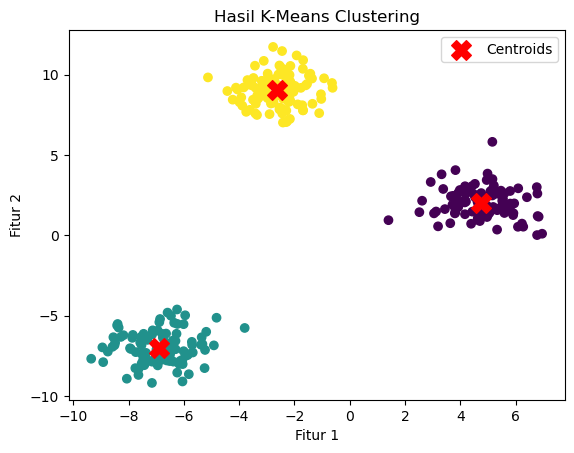

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Membuat data contoh dengan 3 kelompok
n_samples = 300
n_features = 2
n_clusters = 3

# Membuat data contoh dengan fungsi make_blobs
X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

# Menggunakan algoritma K-Means dengan 3 kelompok
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

# Mendapatkan lokasi dari centroid
centroids = kmeans.cluster_centers_

# Mendapatkan label kelompok untuk setiap data
labels = kmeans.labels_

# Plot hasil clustering
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.legend()
plt.title('Hasil K-Means Clustering')
plt.xlabel('Fitur 1')
plt.ylabel('Fitur 2')
plt.show()
